In [1]:
import numpy as np
import pims
from lib import detection
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import stats
from scipy import signal
from skimage import feature
import math

In [30]:
movie = pims.TiffStack('data/videos/OPP/0IYVHRNA.tif')
markers = detection.import_xml_data('data/videos/OPP/0IYVHRNA-ZYW-1.xml')
markers_subset = [marker for marker in markers if marker[2] in range(1975,2275)]
markers_subset = [[marker[0], marker[1], marker[2]-1975] for marker in markers_subset]
movie_subset = movie[1974:2274]

mask = detection.get_mask(movie_subset)
masked_subset = movie_subset * mask

sigma = 1.26
frame = masked_subset[0]

In [79]:
def gauss_laplace_fa(frame, sigma):
    window = math.ceil(4*sigma)
    fg = ndimage.gaussian_filter(frame, sigma)
    extended_frame = np.pad(frame, window, mode='reflect')

    x = np.arange(-window, window+1)
    gauss_1d = np.exp(-np.power(x,2)/(2.*sigma**2.))
    gx2 = gauss_1d*x**2
    
    imgLoG = (2*fg/sigma**2 - 
              (signal.convolve2d(gauss_1d*gx2.reshape(-1,1), extended_frame, 'valid') +
               signal.convolve2d(gx2*gauss_1d.reshape(-1,1), extended_frame, 'valid'))/sigma**4)
    imgLoG = imgLoG / (2*math.pi*sigma**2)
    return imgLoG

def gauss_laplace_scipy(frame, sigma):
    fg = ndimage.gaussian_filter(frame, sigma)
    imgLoG = ndimage.gaussian_laplace(fg, sigma)
    return imgLoG

(-0.5, 299.5, 299.5, -0.5)

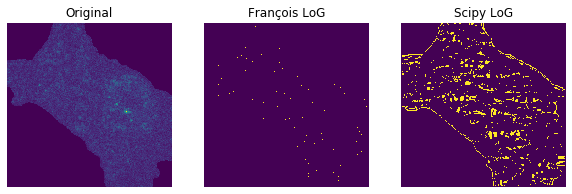

In [80]:
sigma = 3
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,15))
axs = axs.ravel()
axs[0].imshow(frame)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(feature.peak_local_max(-gauss_laplace_fa(frame,sigma), indices=False))
axs[1].set_title(u'François LoG')
axs[1].axis('off')
axs[2].imshow(feature.peak_local_max(-gauss_laplace_scipy(frame,sigma), indices=False))
axs[2].set_title('Scipy LoG')
axs[2].axis('off')

(-0.5, 299.5, 299.5, -0.5)

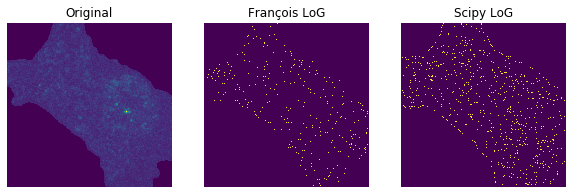

In [10]:
averaged_subset = ndimage.uniform_filter(movie_subset[:], size=(5,0,0))
masked_average = averaged_subset * mask
frame = masked_average[0]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,15))
axs = axs.ravel()
axs[0].imshow(frame)
axs[0].set_title('Original')
axs[0].axis('off')
axs[1].imshow(feature.peak_local_max(-gauss_laplace_fa(frame,sigma), indices=False))
axs[1].set_title(u'François LoG')
axs[1].axis('off')
axs[2].imshow(feature.peak_local_max(-gauss_laplace_scipy(frame,sigma), indices=False))
axs[2].set_title('Scipy LoG')
axs[2].axis('off')

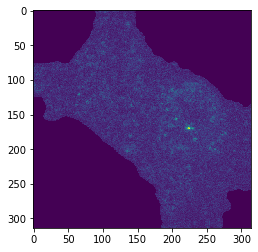

In [85]:
plt.imshow(np.pad(frame,7,mode='reflect'))

In [68]:
from tifffile import imsave
imsave('peak_local.tiff', feature.peak_local_max(-gauss_laplace_fa(frame,sigma), indices=False))
imsave('frame.tiff',frame)

In [25]:
import multiprocessing
from functools import partial
from skimage.draw import circle
from scipy.stats import gumbel_r
import pandas as pd
import time

import trackpy as tp

In [76]:
def _find_locs_in_frame(idx_frame, sigma_list, cutoff):
    """Single frame processor for movies. Denoises, blob detects,
    and calculates background information to identify potential events
    Parameters
    ----------
    idx_frame : list
        A 2-element list, containing the frame number (int) and frame (pims.Frame) to be analysed
    sigma_list : list
        A list of ints indicating at sigmas the Laplace-on-Gaussian should be evaluated
    cutoff: int
        The quantile at which the fitted distribution of background noise should be thresholded to select
        specific signal
    Returns
    -------
    bls : pandas.DataFrame
        DataFrame containing frame number and the y and x coordinates of each blob detected in the frame.
    """
    # Denoise the frame, apply laplacian for each standard deviation, and find
    # the local max values of the laplacian
    idx = idx_frame[0]
    frame = idx_frame[1]
    gls = [-gauss_laplace_fa(frame, sig) * sig **2 for sig in sigma_list]
    plm = [feature.peak_local_max(x) for x in gls]
    plmval = np.concatenate([[gls[i][r, c] for (r, c) in plm[i]] for i in range(len(sigma_list))])
    sigmas_of_peaks = np.concatenate([np.repeat(sigma_list[i], len(plm[i])) for i in range(len(sigma_list))])
    plm = np.hstack([np.concatenate(plm), sigmas_of_peaks.reshape(len(sigmas_of_peaks), 1)])

    loc_background = np.zeros(len(plm))
    for i, loc_max in enumerate(plm):
        rr, cc = circle(loc_max[0], loc_max[1], 9)
        cc_new = cc[np.where((0 <= rr) & (rr <= frame.shape[0] - 1) & (0 <= cc) & (cc <= frame.shape[1] - 1))]
        rr_new = rr[np.where((0 <= rr) & (rr <= frame.shape[0] - 1) & (0 <= cc) & (cc <= frame.shape[1] - 1))]
        loc_background[i] = np.median(frame[rr_new, cc_new])

    coef = detection.gev_glm(plmval, sigmas_of_peaks, loc_background)
    thresh = gumbel_r.ppf(q=cutoff,
                          loc=coef[0] + coef[1]*sigmas_of_peaks + coef[2]*loc_background + coef[3]*sigmas_of_peaks*loc_background,
                          scale=coef[4] +coef[5]*sigmas_of_peaks + coef[6]*loc_background + coef[7]*sigmas_of_peaks*loc_background)
    plm = plm[np.where(plmval > thresh)]
    bls = detection._prune_blobs(plm)

    # record current frame number, rather than the sigma used in blob detection
    bls[:,2] = idx

    # Important note! blob_log function returns (row, col, sigma)
    # row corresponds to y and column to x
    bls = pd.DataFrame(bls, columns=['y', 'x', 'frame'])
    return bls[['frame', 'x', 'y']]

# Function to detect blobs in cell videos
# Returns a pandas data frame with columns for (x,y) location and frame number (0-indexed) for detected blobs
# The output of this function can then be the input for particle tracking to link blobs across frames

# f: array or list of frames from cell video
# max_sigma: largest standard deviation considered for LoG blob detection
# min_sigma: smallest standard deviation considered for LoG blob detection
# num_sigma: number of standard deviations to try in blob detection
# cutoff: the cutoff used to find an intensity threshold

def find_locs(f, max_sigma=3, min_sigma=1, num_sigma=11, cutoff=0.9, mask=True):

    # Generate list of evenly-spaced standard deviations between min_sigma and max_sigma
    scale = np.linspace(0, 1, num_sigma)[:, None]
    sigma_list = scale * (max_sigma - min_sigma) + min_sigma
    sigma_list = sigma_list[:,0]


    n_cores = multiprocessing.cpu_count()
    f_with_sigmas = partial(_find_locs_in_frame, 
                            sigma_list=sigma_list, 
                            cutoff=cutoff)
    if mask:
        f_mask = detection.get_mask(f)
        f = f*f_mask
    
    with multiprocessing.Pool(3) as pool:
        blobs_out = pool.map(f_with_sigmas, enumerate(f), chunksize=100)

    # To do particle tracking across frames, after calling this function you would run the following:
    #
    # events = tp.link_df(locs, search_range=search_range, memory=memory)
    # events = tp.filter_stubs(events, track_length_min)
    #
    # for specified values of
    # search_range: restriction on number of pixels the particle can move from frame to frame
    # memory: number of frames the particle can disappear for
    # track_length_min: minimum number of frames a track must exist for

    locs = pd.concat(blobs_out, ignore_index=True)

    return locs

In [96]:
st_time = time.time()
locs = detection.find_locs(averaged_subset, cutoff=0.9)
end_time = time.time() - st_time
events = tp.link_df(locs, search_range=1.5, memory=0)
events = tp.filter_stubs(events, 4)
puff_ids = np.array([detection.filter_df(events, m, 5) for m in markers_subset])
print(end_time)
report_performance(events, puff_ids, markers_subset)

ValueError: too many values to unpack (expected 2)

In [ ]:
from lib import display
intensities = detection.intensity_grid(movie_subset, events)
for puff_id in puff_ids[puff_ids>0]:
    frames = display.get_frames(intensities.loc[intensities['particle'] == puff_id,:])
    fig, axs = display.plot_montage(frames)

In [38]:
def report_performance(events, puff_idsmovie_subsets):
    num_puffs = np.shape(np.array(markers))[0]
    detected_puffs = np.sum(puff_ids>0)
    unique_puffs = len(np.unique(puff_ids[puff_ids>0]))
    num_events = len(np.unique(events['particle']))
    puff_freq = unique_puffs/num_events
    print('%d/%d puffs (%d unique) in %d events (%.5f freq)' % 
          (detected_puffs, num_puffs, unique_puffs, num_events, puff_freq))